<a href="https://colab.research.google.com/github/GDS-Education-Community-of-Practice/DSECOP/blob/atalla_nmr_module_1/Modules/01_nmr_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NMR Spectrum Analysis Using Artificial Neural Networks


---


#### Authored by Sebastian W. Atalla
##### UNC Chapel Hill | Dept. of Physics & Astronomy



## **Background**

The Fourier transform is one of the most important concepts in signal processing. It translates an acquired signal between its time and frequency domain representations, allowing for the decomposition of a singal into its constituent frequencies, or construction of a signal from those frequencies.

The Fourier transform, $F(k)$, and its inverse transformation, $f(x)$, are generally given by

\begin{equation}
  F(k) = \int_{-\infty}^{\infty} f(x) \, e^{-2\pi i k x} \, dx  
  \qquad \qquad
  f(x) = \int_{-\infty}^{\infty} F(k) \, e^{2\pi i k x} \, dk
\end{equation}

respectively. The Fourier transform as as defined above may be naively computed via the discrete Fourier transform (DFT) and its inverse transformation,

\begin{equation}
  X_k = \sum_{n=0}^{N-1} x_n \, e^{-i\frac{2\pi}{N}kn}
  \qquad \qquad
  x_n = \frac{1}{N} \sum_{k=0}^{N-1} X_k \, e^{i\frac{2\pi}{N}kn}
\end{equation}

respectively; however, this is remarkably ineffificent compared to the modern fast Fourier transform (FFT) utilized in practically all computational domains.

The Fourier transform is used to great effect in nuclear magnetic resonance (NMR) spectroscopy, which exploits the fact that different atomic species resonate at different frequencies in a magnetic field as defined by their gyromagnetic ratio – a phenomenon known as spin precession. Faraday induction is used to detect the precession of the magnetization vector of the nuclear spins, which yields the magnetization amplitude as a function of time. The DFT decomposes this signal into discrete frequencies that may be interpreted in terms of chemical shift, which is a field-independent representation of a nucleus’s resonant frequency.

This same principle is utilized heavily in magnetic resonance imaging (MRI), in which images are reconstructed via a 2-dimensional FFT from data collected by the MRI machine in *k-space*, which represents spatial frequencies in the acquired image.

## Deep Learning Applications

Deep learning is a sub-discipline of machine learning that encompasses the concept of neural networks. Theoretically, neural networks scale better than traditional computational methods for large amounts of data. This is particularly important for signal processing, since some datasets (e.g., magnetic resonance imaging data) can be extremely large. Deep learning algorithms attempt to learn features about the data; however, in the context of traditional computation and the DFT, the features are intrinsic to the signal. Therein arises the point of this module – can a neural network estimate the frequency content of a signal? 

### **Disclaimer**

The FFT algorithm is efficient and exact. Practically, the Fourier transform is a poor application of deep learning; however, the exactness of the computation (which provides a ground truth for the network's predictions) and the litany of features that may be discerned from the data render it a good thought experiment for learning about neural net architecture and feature engineering.

## Preparation

Packages, constants, and generates are imported and defined in the following cells.

In [ ]:
# Computation
import numpy as np
from numpy.random import default_rng
import scipy
import scipy.optimize
import scipy.signal
import scipy.integrate

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sb

#  Machine learning
import tensorflow as tf
from tensorflow import keras

In [ ]:
# If problems arise while editing NN parameters, run this cell to clear persistent graph data.
tf.keras.backend.clear_session()

In [ ]:
# Define a constant for pi since `np.pi` is clumsy, and it's preferable to not import it
PI = np.pi

# Random generator
rng = np.random.default_rng()

# **Exercise 1** Estimation of FID Frequency Content from FFT

This exercise explores the fidelity of a neural net trained on an NMR signal and the frequency content from that signal's FFT. The signals are simulated from the expression describing a free induction decay (FID), a waveform prevalent in the common single-pulse sequences used in NMR spectroscopy.

An FID may be described by

\begin{equation}
  FID = \sin{(\omega_0 t)} \, e^{-t/T_2^*}
\end{equation}

where $\omega_0$ and $t$ are of the usual formulation in signal processing, and $T_2^*$ is the effective decay in transverse magnetization of the nucleus being measured.

The NMR spectrometer detects a signal as a series of voltages, which must be digitized by an analog-to-digital (ADC) converter, which binarizes the signal for use on a computer. Sampling by the ADC occurs in regular intervals, which yields the datapoints seen in the FID.

The sampling rate of the ADC must be fast enough that important information in the signal is not lost. The minimum sampling rate, $Δ$, needed to render an accurate signal is

\begin{equation}
  \Delta = \frac{1}{2\,f_{max}}
\end{equation}

where $f_{max}$ is the *Nyquist frequency*.

The Nyquist limit is problematic because NMR frequencies are on the order of megahertz. An ADC cannot digitize fast enough to capture this signal. The solution to this is *RF mixing*, in which two frequencies (typically the observed frequency and a reference frequency) are multiplied to yield sinusoids of sums and differences of the two frequencies,

\begin{equation}
  A\cos{(\omega_0 t)} \, \times \, A\cos{(\omega_{rx} t)} =
  \frac{1}{2}A \big[ \cos{ \big( (\omega_0 + \omega_{rx})t \big)}\big] + \cos{ \big( (\omega_0 - \omega_{rx})t \big)}\big]
\end{equation}

where $\omega_0$ is the Larmor frequency, and $\omega_{rx}$ is the reference frequency. After applying a low-pass filter, the signal of interest is now simply

\begin{equation}
  S = \frac{1}{2}A\left[\cos{ \big( (\omega_0 - \omega_{rx})t \big)}\right] = \frac{1}{2}A\left[\cos{ (\omega_{\text{mix}})t)}\right]
\end{equation}

in which $\omega_{\text{mix}}$ is a frequency that may now be sampled by the ADC.

## Signal Data

The FIDs will be simulated from an array of RF-mixed frequencies spanning 50 Hz to 1 kHz. A series of $T_2^*$ relaxation times will also be used to emulate the spectra in various media (e.g. tissue, water, fat, etc.). 

In [ ]:
# RF=mixed frequencies from 50 Hz to 1 kHz
rf_mix_frequency = np.linspace(50, 1000, num=50, endpoint=True)

# T2 spin-spin relaxation times for proton in various media
spin2_relaxation = np.linspace(0.1, 4, num=25, endpoint=True) # Seconds

# Nyquist limit for highest frequencu; satisfies all Nyquist limit reqs. for lower frequencies
min_sampling_freq = 2 * rf_mix_frequency.max() # Hertz

# Sampling that satisfies the Nyquist limit for the highest RF-mixed frequency
time = np.arange(0, 1, 1/(2*min_sampling_freq)) # Seconds

In [ ]:
def fid_sim(w0, t, T2, phase_shift = 0):
   """ Simulates a free induction decay (FID). """
   return np.sin(2*PI * w0 * t + phase_shift) * np.exp(-t/T2)

In [ ]:
# At least one of the args needs to be Iterable to make a table; for simplicity, enforce it on all args
def make_fid_table(frequency, timepts, relaxation):
   """ Constructs a table of simulated FIDs. """
   # Use list for efficient append
   fid_table = []

   # `sz_dim` is the number of signals generated
   sz_dim = len(frequency) * len(relaxation)

   # Generate amplitude scaling and phase shifting factors to introduce more variance
   amplitude_scale_table   = rng.uniform(1, 10, sz_dim)
   phase_shift_table       = rng.uniform(0, 2*PI, sz_dim)

   # Iterate over each relaxation time for each frequency
   for w0 in frequency:
      for t2 in relaxation:
         # Randomly select an amplitude scaling factor and phase shift
         amp = rng.choice(amplitude_scale_table)
         phi = rng.choice(phase_shift_table)

         # Generate fid and append to the FID table
         fid = amp * fid_sim(w0, timepts, t2, phase_shift=phi)
         fid_table.append(fid)

   # Cast the list to an ndarray
   fid_table = np.asarray(fid_table)

   # Add some Gaussian noise to better simulate a real signal
   noise = rng.normal(-0.05, 0.05, fid_table.shape)
   noisy_fid = fid_table + noise

   # Shuffle the generated FIDs
   rng.shuffle(noisy_fid)

   return noisy_fid

The following cell contains the simulated FIDs.

In [ ]:
# Table of simulated FIDs to serve as observed NMR spectra.
observed_fid_table = make_fid_table(rf_mix_frequency, time, spin2_relaxation)

The next step is to compute the Fourier transform of the FIDs that have just been generated. 

In [ ]:
def make_window(arr):
    """ Windows the input array relative to a signal's upper Nyquist band. """
    return arr[:int(np.ceil(len(arr)/2))]

def transform_fid_table(fid_table):
    """ Computes the forward FFT of the input FID array and returns the upper Nyquist band. """
    # Use a list for efficient append
    fid_transform_table = []

    # Iterate over each FID in the FID table
    for fid in fid_table:
        # Computes forward FFT and scales with the FID length
        fid_ft      = np.fft.fft(fid)/len(fid)
        # Collects complex modulus of the frequency-domain signal
        abs_ft      = np.abs(fid_ft)
        # Windows the FFT output to the upper Nyquist band
        win_fid_ft  = make_window(abs_ft)

        fid_transform_table.append(win_fid_ft)

    # Cast the list to an ndarray
    transformed_fid_table = np.asarray(fid_transform_table)

    return transformed_fid_table

The following cell contains the Fourier transforms of the generated FIDs.

In [ ]:
ft_table = transform_fid_table(observed_fid_table)

The follow cell is the frequency range of the signals, respective to the minimum sampling rate dictated by the highest frequency with which the FIDs were generated.

In [ ]:
# Frequency range based on Nyquist limit
xfrq = make_window(np.fft.fftfreq(n=len(time), d=1/(2*min_sampling_freq)))

## The Neural Network

Can a neural network learn to decipher the frequency content of an observed FID? The first attempt will make use of simple artificial neural network (ANN) architecture trained on the FIDs and their respective FFT. This neural network consists of sequential dense, or fully-connected, layers which forms the *model*. The dense layers have several tunable parameters, otherwise known as *hyperparameters*. The `Dense` layer is defined in Keras as

```python
tf.keras.layers.Dense(
    units,
    activation = None,
    use_bias = True,
    kernel_initializer = "glorot_uniform",
    bias_initializer = "zeros",
    kernel_regularizer = None,
    bias_regularizer = None,
    activity_regularizer = None,
    kernel_constraint = None,
    bias_constraint = None,
    **kwargs)
```
where the arguments provided represent the default values instantiated by Keras.

Some of the most commonly tuned hyperparameters are `units`, which corresponds the output dimensions of the layer (i.e. the number of *nodes*), and `activation` to specify which activation function should be used. The number of layers in the model is also a tunable hyperparameter.

An important note about hyperparameters is that they are not universally constant - they require tuning by the user. This means that a network will potentially undergo many iterations before the quality of its predictions is satisfactory to the user.


The largest hurdle in developing a neural network is understanding what the network is supposed to be solving. In the forward direction, the FFT is a linear transformation between the time-domain and frequency-domain representations of a signal. Thus, it behaves more like a regression than a classification. This immediately limits our choice of activation function, making the `activation` hyperparameter simple to tune.

Keras maintains several activation functions. Some of the most popular are `sigmoid`, `softmax`, `relu`, and `tanh`. Logit-type Functions such as `sigmoid` and `softmax` are more useful in the final layer of network classifers, since they normalize the output to a probability distribution. That means `relu`-type and `linear` activation functions are preferred, since they generally allow the output to remain unconstrained between $-\infty$ and $\infty$.

An exaustive list of Keras's activation functions and short descriptions of each may be found in the [Keras Activation Function API](https://keras.io/api/layers/activations/#available-activations) documentation.

### Exercise 1

The ANN below is able to learn an FIDs frequency content, but it has trouble learning the amplitude and spectral-width of the center frequency. Adjust the parameters shown in the `Dense` API listed above. 

*   Focus on units and activation functions.
*   Leave the initializers as default - these specify how the weights and biases are initialized in the model.

When using linear activation functions, the biases should be less impactful, as they will introduce a constant to the activation function that shifts the weight (akin to the intercept term $b$ of the slope-intercept form of the line equation, $y=mx+b$).

\
The number of layers in a model is a readily tunable hyperparameter. The number of nodes in a layer is also a tunable hyperparameter. These hyperparameters represent the foundation of the model. The following ANN consists of a sequence of `Dense` layers, for which the rule of thumb is that more layers are better.$^1$

---

**Exercise 1.1** Try adding and removing `Dense` layers with varying numbers of nodes. Do any trends regarding the number of nodes and layers stick out? The [Keras Dense Layer API](https://keras.io/api/layers/core_layers/dense/) lists the arguments necessary for instantiating a `Dense` layer.

\
As mentioned above, different activation functions are better suited for different problems. Using the wrong activation function can cause a neural network to yield poor output.

---

**Exercise 1.2** Try different activation functions in one, some, or all layers; however, limit the functions to `sigmoid`, `softmax`, `relu`, and `linear`. A linear activation function is the default value of a Keras `Dense` layer, specified by `activation = None` What differences in behavior arise when using different classes of activation function? Arguments for the activation functions may be found in the [Keras Activation Function API](https://keras.io/api/layers/activations/) documentation.

\
Regularizers may have some value, especially LASSO/L1 regularization, which is well suited for sparse problems where less important features can have their coefficients weighted towards zero. However, each point in the DFT is a sum of every point in the time-domain signal. 

---

**Exercise 1.3** Is this problem sparse? Try tuning (with small numbers less than 1) the `L1` regularizer at the kernel level on one, some, or all layers to see how this affects the neural network's ability to learn. This can be implemented in the `Dense` layer via
```python
  kernel_regularizer = keras.regularizers.L1(l1=0)
```
Further information about layer arguments may be found in the [Keras Layers API](https://keras.io/api/layers/core_layers/) documentation.

\
Another important hyperparameter is the learning rate, which determines the step size at each iteration as the model minimizes the loss function. Increasing the learning rate causes the model to converge faster. If the learning rate is too high, this can cause convergence on a poor solution, but if it's too low then convergence may never occur. Decay can slow the learning rate down until a minimum solution is found. 

---

**Excercise 1.4** Tune the hyperparameters in `lr_schedule` and observe the effect on `loss` and `val_loss`. Learning rate schedules and API usage are listed in the [Keras Learning Schedule API](https://keras.io/api/optimizers/learning_rate_schedules/) documentation.

\
The optimizer is the function that minimizes the loss function. The optimizer used in this network is *Stochastic Gradient Descent* (SGD), and the loss function is the *mean squared error* (MSE). SGD finds the derivatives of the loss function in order to find local minima. This method is susceptible to vanishing and exploding gradients, which result in weights being calculated as `nan`. The `clipnorm` argument in the optimizer clips exploding gradients at `1.0`. The `momentum` hyperparameter helps the optimizer maintain some degree of the previous optimization's direction with each iteration. 

---

**Exercise 1.5** Try different optimizers and try tuning the optimization hyperparameters. From the descriptions of the optimizers, why might some be poorly suited to this problem? The possible optimizers for use with Keras models are listed in the [Keras Optimizers API](https://keras.io/api/optimizers/#available-optimizers) documentation.

\

\

### References

---

[1] [Bengio, Yoshua. "Practical recommendations for gradient-based training of deep architectures." Neural networks: Tricks of the trade. Springer Berlin Heidelberg, 2012. 437-478.](https://arxiv.org/abs/1206.5533)

In [ ]:
model_ft = keras.models.Sequential([
    # Input layer
    keras.layers.Input(
        shape = observed_fid_table.shape[1]
    ),
    # Hidden layer 1
    keras.layers.Dense(
        #activation  = tf.nn.relu,
        units       = observed_fid_table.shape[1],
        use_bias    = False,
        kernel_regularizer = keras.regularizers.L1(
            l1 = 1e-4
        )
    ),
    # Hidden layer 2
    keras.layers.Dense(
        #activation  = tf.nn.relu,
        units       = int(np.ceil(observed_fid_table.shape[1]/2)),
        use_bias    = False
    ),
    # Hidden layer 3
    keras.layers.Dense(
        #activation  = tf.nn.relu,
        units       = int(np.ceil(observed_fid_table.shape[1]/2)),
        use_bias    = False
    ),
    # Output layer
    keras.layers.Dense(
        # Linear activation - regression-type problem
        units       = ft_table.shape[1],
        use_bias    = False
    )
])

# Callback to stop the model early based on `val_loss` to prevent overfitting
early_stop_callback = keras.callbacks.EarlyStopping(
    monitor   = 'val_loss', 
    min_delta = 1e-4, 
    patience  = 10, 
    mode      = 'auto',
    verbose   = 1,
    baseline  = None
    )

# Learning rate schedule to decrease the learning rate over the training period
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate   = 0.1,
    decay_steps             = 500,
    decay_rate              = 0.96
)

model_ft.compile(
    loss        = 'mean_squared_error', 
    optimizer   = tf.keras.optimizers.SGD(
        learning_rate = lr_schedule,
        momentum      = 0.5,
        # Prevents vanishing/exploding gradients
        clipnorm      = 1.0
        )
    )

model_ft.fit(
    x                 = observed_fid_table, 
    y                 = ft_table, 
    epochs            = 300, 
    batch_size        = 50,
    # Train on 80% of the input data, validate on 20%
    validation_split  = 0.2,
    verbose           = 1,
    callbacks         = [early_stop_callback]
    )

Epoch 1/300
20/20 [==============================] - 4s 23ms/step - loss: 27.9778 - val_loss: 23.1005
Epoch 2/300
20/20 [==============================] - 0s 15ms/step - loss: 22.3918 - val_loss: 22.0287
Epoch 3/300
20/20 [==============================] - 0s 15ms/step - loss: 21.7935 - val_loss: 21.6280
Epoch 4/300
20/20 [==============================] - 0s 14ms/step - loss: 21.3940 - val_loss: 21.2968
Epoch 5/300
20/20 [==============================] - 0s 15ms/step - loss: 21.0297 - val_loss: 20.9193
Epoch 6/300
20/20 [==============================] - 0s 14ms/step - loss: 20.6583 - val_loss: 20.4908
Epoch 7/300
20/20 [==============================] - 0s 15ms/step - loss: 20.2957 - val_loss: 20.0796
Epoch 8/300
20/20 [==============================] - 0s 14ms/step - loss: 19.8747 - val_loss: 19.6795
Epoch 9/300
20/20 [==============================] - 0s 15ms/step - loss: 19.4736 - val_loss: 19.2706
Epoch 10/300
20/20 [==============================] - 0s 15ms/step - loss: 19.0511

A summary of the neural network may be seen below. The number of parameters is exceptionally large. When working with unmixed frequencies in the MHz regime, the Nyquist limit would rapidly drive the number of parameters beyond the point of overflow.

In [ ]:
model_ft.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4000)              16000000  
                                                                 
 dense_1 (Dense)             (None, 2000)              8000000   
                                                                 
 dense_2 (Dense)             (None, 2000)              4000000   
                                                                 
 dense_3 (Dense)             (None, 2000)              4000000   
                                                                 
Total params: 32,000,000
Trainable params: 32,000,000
Non-trainable params: 0
_________________________________________________________________


### ANN Predictions

An FID may be submitted to the model via the `predict()` method, which will return the neural network's estimation of the FID's frequency spectrum.

In [ ]:
def nn_fft(input):
    prediction = model_ft.predict(input[np.newaxis])[0]
    return prediction

In [ ]:
#all_nn_pred = np.asarray([nn_fft(x) for x in observed_fid_table])
#all_nn_freq = [xfrq[np.argmax(x)] for x in all_nn_pred]
#all_ft_freq = [xfrq[np.argmax(x)] for x in ft_table]

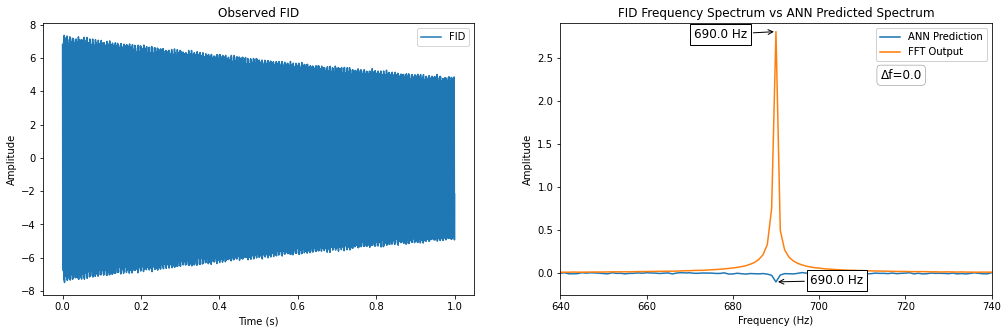

In [ ]:
#@title ANN Predictions Visualized
#@markdown Press the `Play` button on the left side of the cell to visualize the ANN predictions for a randomly selected FID. On the left is the submitted FID, and on the right is a superimposition of the ANN prediction and the real FFT output for that FID.
#@markdown The frequency in the ANN Prediction callout is the center frequency predicted by the network. Check the results of hyperparameter tuning against the output in this figure.
#@markdown
#@markdown ---
#@markdown **Exercise 1.1.6** Run this code several times and observe how the network's estimated resonant frequency compares to the real frequency from the FFT.
n_samples = len(rf_mix_frequency) * len(spin2_relaxation)
rand_idx = rng.integers(low = 0, high = n_samples)
rand_sample = observed_fid_table[rand_idx]

nn_test = nn_fft(rand_sample)
ft_real = make_window(np.abs(np.fft.fft(rand_sample)/len(rand_sample)))

nn_peak_at = np.argmax(np.abs(nn_test))
ft_peak_at = np.argmax(ft_real)
peak_mean = np.mean([nn_peak_at, ft_peak_at])

nn_freq = xfrq[nn_peak_at]
ft_freq = xfrq[ft_peak_at]

#*_, axis = plt.subplots(1, 3, figsize = (24, 5))
*_, axis = plt.subplots(1, 2, figsize = (17, 5))
sb.lineplot(x = time, y = rand_sample, ax = axis[0], label = 'FID')
sb.lineplot(x = xfrq, y = nn_test, ax = axis[1], label = f'ANN Prediction')
sb.lineplot(x = xfrq, y = ft_real, ax = axis[1], label = f'FFT Output')

axis[0].set(title="Observed FID", xlabel="Time (s)", ylabel="Amplitude")
axis[1].set(title="FID Frequency Spectrum vs ANN Predicted Spectrum", xlabel="Frequency (Hz)", ylabel="Amplitude")

# Annotations
arrow_args = dict(arrowstyle='->')
bbox_args = dict(boxstyle='square', fc='white')
bbox_args2 = dict(boxstyle='round', fc='white', edgecolor='gray', linewidth = 0.5)

nn_amp = nn_test[nn_peak_at]
ft_amp = ft_real[ft_peak_at]

if (nn_amp < 0): 
  nn_y_annotate = nn_amp - 0.025
else:
  nn_y_annotate = nn_amp + 0.01

axis[1].annotate(f'{nn_freq} Hz', xy=(nn_freq, nn_amp), xytext=(nn_freq + 8, nn_y_annotate), arrowprops=arrow_args, bbox=bbox_args, fontsize=12)
axis[1].annotate(f'{ft_freq} Hz', xy=(ft_freq, ft_amp), xytext=(ft_freq - 19, ft_amp-0.075), arrowprops=arrow_args, bbox=bbox_args, fontsize=12)

first_legend = axis[1].legend()
axis[1].add_artist(first_legend)

axis[1].annotate(f'Δf={np.abs(nn_freq-ft_freq)}', xy=(0.7425, 0.795), xycoords='axes fraction', bbox=bbox_args2, fontsize=12)

# `np.isclose(a, b)` assumed b is the reference value
if np.isclose(nn_peak_at, ft_peak_at, atol = 5):
  axis[1].set_xlim(peak_mean - 50, peak_mean + 50)

if (nn_amp < 0):
  axis[1].set_ylim(nn_amp - 0.15, ft_amp + 0.1)

### Discussion
The neural network with the hyperparameters provided in this module was able to successfully learn the frequency content of the majority of FIDs submitted to the predictor. The network showed little capacity for learning the amplitude or spectral width of the center frequency. Some solutions to this problem are adding more layers or further tuning of the hyperparameters.

There exists an alternative to the approach above. Rather than training the network on the FID and its corresponding frequency spectrum, a network may be trained on the FID and the information one expects to discern from the spectrum.

This approach is advantageous because it significantly reduces the number of outputs, and subsequently the number of training parameters. The next exercise in this module will explore this approach in more depth.

# **Exercise 2** Estimation of Lorentzian Curve Fitting Parameters from FID Frequency Spectra

In the previous exercise, it was found that the ANN failed to produce meaningful estimates of the amplitude and spectral width of the FID's center frequency. This information is important in spectroscopy. For instance, in $^1$H NMR, the area under the peak is proportional to the number of protons producing that peak. The sum of the peak integrals represents the number of hydrogens in a substance, which allows for estimation of a substance's molecular formula. Thus, without accurate amplitude and width data, predicting the center frequency is functionally useless.

## Curve Fitting of NMR Data

Determining the location, amplitude, and spectral width of a spectrum's resonant frequency is easily done by fitting the peak to a spectral line shape function. The most common line shapes encountered in NMR are *Lorentzian*, *Gaussian*, and *Voigt*.

\
#### **Lorentzian Distribution**
The Lorentzian line shape function is given by its probability density function (PDF),

\begin{equation}
  L(x; x_0, A, \gamma) = \frac{A}{\pi}\left(\frac{\gamma}{(x-x_0)^2 + \gamma^2}\right)
\end{equation}

where $x_0$ is the location of the resonant frequency, $A$ is the amplitude, and $\gamma$ is the FWHM corresponding to the spectral width.

\
#### **Gaussian Distribution**
Gaussian line shapes are similarly given by their PDF as

\begin{equation}
  G(x; \mu, A, \sigma) = \frac{A}{\sigma\sqrt{2\pi}}\exp\left(-\frac{(x-\mu)^2)}{2\sigma^2}\right)
\end{equation}

where $\mu$ corresponds to the location of the resonant frequency, $A$ is again the amplitude, and $\sigma$ is the FWHM describing the spectral width. 

\
#### **Voigt Profile**
The Voigt profile is a convolution of the Lorentzian and Gaussian line shapes, and is given by

\begin{equation}
  V(x; \sigma, \gamma) = \int_{-\infty}^{\infty}\,G(x';\sigma)L(x-x';\gamma)\,dx'
\end{equation}

There is no closed-form expression for the Voigt profile, but may be approximated from the real part of the Faddeeva function $w(z)$,

\begin{equation}
  V(x; \sigma, \gamma) = \frac{\Re\left[w(z)\right]}{\sigma\sqrt{2\pi}}, \qquad z=\frac{x+iy}{\sigma\sqrt{2}}
\end{equation}

Computing $w(z)$ is computationally expensive, so the Voigt profile is most often approximated using a pseudo-Voigt profile,

\begin{equation}
  pV(x; \sigma, \gamma) = \eta G(x;\sigma) + (1-\eta)L(x;\gamma)
\end{equation}

where $\eta$ is a parameter bound between 0 and 1 that shifts the profile towards pure Gaussian or pure Lorentzian when approaching 1 or 0, respectively.

### Lorentzian Fit

The function below defines a Lorentzian line shape that is callable by `scipy.optimize.curve_fit()`. The parameters being estimated are the location of the resonant frequency, the amplitude of the peak, and the width of the peak.

In [ ]:
def lorentzian(x, x0, amp, gamma):
    """ Callable Lorentzian distribution for use with `scipy.optimize.curve_fit() """
    loc_param = (x - x0)**2     # est. location param - peak location
    scl_param = gamma**2        # scale param specifying FWHM

    # Probability density function for Lorentzian distribution 
    lorentz_pdf = (amp/PI) * (gamma / (loc_param + scl_param))

    return lorentz_pdf

The curve fitting algorithm provided by `scipy` works best with initial guesses for the parameters. The peak locations and amplitudes may be robustly determined from the `scipy.signal.find_peaks()` peak finding algorithm by thresholding valid peaks to a peak prominence limited by the signal-to-noise ratio (SNR) of the frequency spectrum.

In [ ]:
def fit_spectrum_lorentzian():
    """ Fits the Fourier transform spectrum to a Lorentzian PDF for parameter estimation """
    popt_table = []

    # peak prominence threshold determined from SNR
    snr_pdiff = 0.049

    for spectrum in ft_table:
        # Determine index of maximum amplitude
        # peaks = np.argmax(spectrum) # Less robust than peak finding

        # Determines peak based on prominence of peak relative to depth of side lobes
        # Adjust prominence until desired number of peaks are found
        peaks, _ = scipy.signal.find_peaks(
            x           = spectrum, 
            prominence  = snr_pdiff
            )
        amp_at_center_frq = int(peaks[0])

        # Estimate the the amplitude and location (x0) from the amp_at_center_frq
        amp_pred = spectrum[amp_at_center_frq]
        frq_pred = xfrq[amp_at_center_frq]

        # Return optimized parameters, discard covariance matrix
        optimized_parameters, *_ = scipy.optimize.curve_fit(
            f       = lorentzian,
            xdata   = xfrq, 
            ydata   = spectrum, 
            method  = 'lm', 
            p0      = [frq_pred, amp_pred, 100]
        )

        popt_table.append(optimized_parameters)

    return np.asarray(popt_table)

opt_params = fit_spectrum_lorentzian()

## The Neural Network

The ANN below is of similar architecture to the one used in Exercise 1. The major difference is the number of training parameters in the network. The input layer remains the same as the first network, but the final layer yields only 3 outputs - the location of the resonant frequency, the amplitude of the peak, and the width of the curve.

### Exercise 2.1

Unlike the linear transformation from an FID to its frequency spectrum in Exercise 1, there exist much more complex relationships between the input and output data in the following ANN due to the addition of a curve-fitting task which the network must learn.

\
Activation functions are especially important for elucidating these complex relationships. Without them, the model behaves as if it only has a single layer and important weights cannot be updated as quickly. In short, the activation functions introduce non-linearity.


---

**Exercise 2.1** Revisit the activation functions introduced in Exercise 1. Tune the `activation` hyperparameter using some of the more advanced functions available. Note how these functions alter the convergence of the validation loss, `val_loss`.

\
Aside from the activation function, all of the same hyperparameters from the network in Exercise 1.1 exist in this network, e.g. the number of layers and the number of nodes within each layer, the learning rate, momentum, etc.


---

**Exercise 2.2** Using Exercise 1 as a reference, tune the hyperparameters in this network so that the validation loss converges. Proceed to the next section and visualize the effect of that tuning on the network's output. If it is unsatisfactory, tune the parameters again and attempt to minimize `val_loss`.

In [ ]:
model_lorentzian = keras.models.Sequential([
    keras.layers.Input(
        shape       = observed_fid_table.shape[1],
    ),
    keras.layers.Dense(
        units               = int(np.ceil(observed_fid_table.shape[1]/2)),
        activation          = tf.nn.swish,
        use_bias            = False
    ),
    keras.layers.Dense(
        units               = int(np.ceil(observed_fid_table.shape[1]/4)),
        activation          = tf.nn.relu6,
        use_bias            = False
    ),
    keras.layers.Dense(
        units               = int(np.ceil(observed_fid_table.shape[1]/8)),
        activation          = tf.nn.relu6,
        use_bias            = False
    ),
    keras.layers.Dense(
        units               = int(np.ceil(observed_fid_table.shape[1]/16)),
        activation          = tf.nn.selu,
        use_bias            = False
    ),
    keras.layers.Dense(
        units               = int(np.ceil(observed_fid_table.shape[1]/32)),
        activation          = tf.nn.relu,
        use_bias            = False
    ),
    keras.layers.Dense(
        units               = int(np.ceil(observed_fid_table.shape[1]/128)),
        activation          = tf.nn.relu,
        use_bias            = False
    ),
    keras.layers.Dense(
        # Linear activation in final later - regression-type problem
        activation  = None,
        units       = opt_params.shape[1],
    )
])

lr_schedule_fit = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate   = 0.2,
    decay_steps             = 50,
    decay_rate              = 0.96,
    staircase               = True
    )

early_stop_callback = keras.callbacks.EarlyStopping(
    monitor   = 'loss', 
    min_delta = 1e-4, 
    patience  = 10, 
    mode      = 'auto',
    verbose   = 1,
    baseline  = None
    )

model_lorentzian.compile(
    loss        = 'mean_squared_error', 
    optimizer   = tf.keras.optimizers.SGD(
        learning_rate   = lr_schedule_fit,
        momentum        = 0.5,
        clipnorm        = 1.0
        )
    )

history = model_lorentzian.fit(
    x           = observed_fid_table, 
    y           = opt_params, 
    epochs      = 300, 
    batch_size  = 25,
    # Train on 80% of the input data, validate on 20%
    # validation_split  = 0.2,
    callbacks   = [early_stop_callback]
    )

Epoch 1/300
50/50 [==============================] - 1s 6ms/step - loss: 31942.6328
Epoch 2/300
50/50 [==============================] - 0s 5ms/step - loss: 13619.1426
Epoch 3/300
50/50 [==============================] - 0s 5ms/step - loss: 10234.4180
Epoch 4/300
50/50 [==============================] - 0s 5ms/step - loss: 8328.2383
Epoch 5/300
50/50 [==============================] - 0s 5ms/step - loss: 6888.1602
Epoch 6/300
50/50 [==============================] - 0s 5ms/step - loss: 6032.9883
Epoch 7/300
50/50 [==============================] - 0s 5ms/step - loss: 5011.5229
Epoch 8/300
50/50 [==============================] - 0s 5ms/step - loss: 4626.7910
Epoch 9/300
50/50 [==============================] - 0s 5ms/step - loss: 4001.0283
Epoch 10/300
50/50 [==============================] - 0s 5ms/step - loss: 3691.1135
Epoch 11/300
50/50 [==============================] - 0s 5ms/step - loss: 3345.3132
Epoch 12/300
50/50 [==============================] - 0s 5ms/step - loss: 3056.577

Consider the model summary below. Note how the number of training parameters is significantly smaller compared to the number of training parameters in the network in Exercise 1.

In [ ]:
model_lorentzian.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 2000)              8000000   
                                                                 
 dense_5 (Dense)             (None, 1000)              2000000   
                                                                 
 dense_6 (Dense)             (None, 500)               500000    
                                                                 
 dense_7 (Dense)             (None, 250)               125000    
                                                                 
 dense_8 (Dense)             (None, 125)               31250     
                                                                 
 dense_9 (Dense)             (None, 32)                4000      
                                                                 
 dense_10 (Dense)            (None, 3)                

### ANN Predictions

An FID may be submitted to the model via the `predict()` method, which will return the neural network's estimation of the frequency spectrum's curve-fit parameters, in the form 
```
[frequency, amplitude, fwhm]
```
where `amplitude` and `fwhm` correspond to the distribution-specific parameters (e.g. $A$ and $\gamma$ for the Lorentzian line shape) that influence those properties of the curve.

In [ ]:
def nn_lorentzian(input):
  prediction = model_lorentzian.predict(input[np.newaxis])[0]
  return prediction

In [ ]:
# Be patient - this function takes some time to run
def all_nn_lorentzian():
  prediction_table = []

  for fid in observed_fid_table:
    fid_fit = nn_lorentzian(fid)
    prediction_table.append(fid_fit)

  return prediction_table

fit_predictions = all_nn_lorentzian()

#### ANN Predictions Visualized

In [ ]:
nn_curve_table = []
ft_curve_table = []

for fit in fit_predictions:
  nn = lorentzian(xfrq, fit[0], fit[1], fit[2])
  nn_curve_table.append(nn)

for fit in opt_params:
  ft = lorentzian(xfrq, fit[0], fit[1], fit[2])
  ft_curve_table.append(ft)

In [ ]:
nn_quad_table = []
ft_quad_table = []

for curve in nn_curve_table:
  cv = scipy.integrate.simps(curve)
  nn_quad_table.append(cv)

for curve in ft_curve_table:
  cv = scipy.integrate.simps(curve)
  ft_quad_table.append(cv)

nn_quad_table = np.asarray(nn_quad_table)
ft_quad_table = np.asarray(ft_quad_table)

cvdiff = np.subtract(nn_quad_table, ft_quad_table)

frqdiff = np.fromiter((fit_predictions[i][0] - opt_params[i][0] for i in range(1250)), dtype=float)

(0.0, 1250.0)

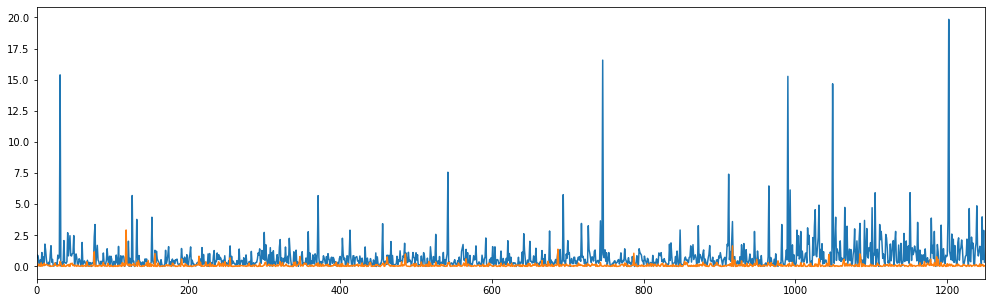

In [ ]:
*_, axs = plt.subplots(1, 1, figsize=(17,5))
sb.lineplot(x=range(1250), y=np.abs(cvdiff), ax=axs)
sb.lineplot(x=range(1250), y=np.abs(frqdiff), ax=axs)
axs.set_xlim(0, 1250)

In [ ]:
num = len(rf_mix_frequency) * len(spin2_relaxation)
random_sample_n = rng.integers(low = 0, high = num)





In [ ]:
test_n = rng.integers(low=0, high=1250)

fit_test = nn_lorentzian(observed_fid_table[test_n])
fit_real = opt_params[test_n]

print(f'Predicted parameters: {fit_test}')
print(f'Expected parameters: {fit_real}')

Predicted parameters: [88.88494    3.451331   0.8003022]
Expected parameters: [88.87568511  3.21032899  0.81925814]


(73.88031310581003, 103.88031310581003)

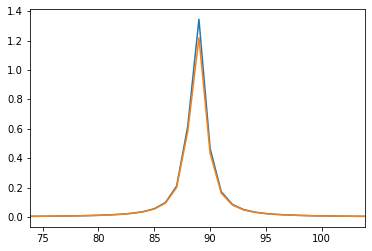

In [ ]:
lorentz_nn_test = lorentzian(xfrq, fit_test[0], fit_test[1], fit_test[2])
lorentz_rl_test = lorentzian(xfrq, fit_real[0], fit_real[1], fit_real[2])

mn = np.mean([fit_test[0], fit_real[0]])
xmin = mn - 15
xmax = mn + 15


fig, ax = plt.subplots()
sb.lineplot(x=xfrq, y=lorentz_nn_test)
sb.lineplot(x=xfrq, y=lorentz_rl_test)
ax.set_xlim(xmin, xmax)

In [ ]:
atest = scipy.integrate.simps(lorentz_nn_test)
print(atest)

atest2 = scipy.integrate.simps(lorentz_rl_test)
print(atest2)

6.60803493584287
5.754867687660493


In [ ]:
np.allclose(lorentz_nn_test, lorentz_rl_test, atol=0.1)

False

### Discussion

Overall, the network trained on the curve fitting parameters reconstructs the frequency content of the FIDs with much higher fidelity than the network trained directly on the spectrum. Both networks display significant room for improvement; however, as was stressed earlier in this module, DFT computation is a poor application for a neural network due to the efficiency and exactness of modern FFT implementations. Nonetheless, the network in Exercise 2 that predicts parameters of best fit is a better problem domain for deep learning, and takes advantage of an ANN's ability to learn complex, nonlinear relationships within data.

\
Outside of the network hyperparameters, one possible area of improvement for the network is the line shape function to which the spectrum is fit. A Lorentzian distribution was utilized initially, but NMR spectra typically fit the Voigt profile better.

---

**Exercise 2.3** Implement the pseudo-Voigt profile as a `curve_fit()` callable function and fit the spectra. Specific details on SciPy curve fitting may be found in the [SciPy Optimize API](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) documentation. Train the network on the new fit parameters and investigate whether or not - and to what degree - the differences between the learned and real spectra have been resolved. 

**Exercise 2.4** Is the line shape function a tunable hyperparameter?